X_train shape: (37730, 32, 32, 1) - y_train shape: (37730, 6)
X_val shape: (9433, 32, 32, 1) - y_val shape: (9433, 6)
X_test shape: (11791, 32, 32, 1) - y_test shape: (11791, 6)


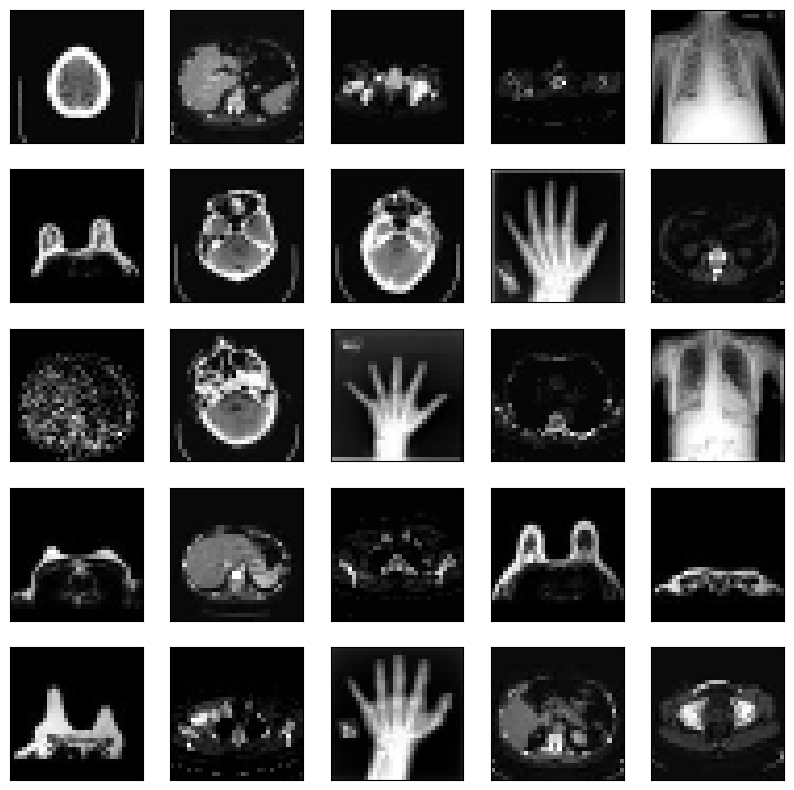


Train dataset:
Input shape: torch.Size([32, 32, 1])
Output shape: torch.Size([6])

Val dataset:
Input shape: torch.Size([32, 32, 1])
Output shape: torch.Size([6])

Test dataset:
Input shape: torch.Size([32, 32, 1])
Output shape: torch.Size([6])
Train dataset size: 37730
Validation dataset size: 9433
Test dataset size: 11791


In [10]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torchvision
from torchvision import transforms
import os
import cv2
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset
import collections.abc
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Define constants
num_classes = 6
input_shape = (32, 32, 1)  # Grayscale, so channel is 1
patch_size = (2, 2)  # 2-by-2 sized patches
dropout_rate = 0  # Dropout rate
num_heads = 8  # Attention heads
embed_dim = 64  # Embedding dimension
num_mlp = 128  # MLP layer size
# Convert embedded patches to query, key, and values with a learnable additive
# value
qkv_bias = True
window_size = 2  # Size of attention window
shift_size = 1  # Size of shifting window
image_dimension = 32  # Initial image size

num_patch_x = input_shape[0] // patch_size[0]
num_patch_y = input_shape[1] // patch_size[1]

learning_rate = 1e-3
batch_size = 128
num_epochs = 2
validation_split = 0.1
weight_decay = 0.0001
label_smoothing = 0.5


import os
import pandas as pd
path = "./MedMNIST"

data = {"imgpath": [] , "labels": [] }

category = os.listdir(path)
for folder in category:
    folderpath = os.path.join(path , folder)
    filelist = os.listdir(folderpath)
    for file in filelist:
        fpath = os.path.join(folderpath, file)
        data["imgpath"].append(fpath)
        data["labels"].append(folder)
df = pd.DataFrame(data)

shuffled_df = df.sample(frac=1, random_state=42)  # Set random_state for reproducibility

# Print the first few rows of the shuffled DataFrame
shuffled_df.head()

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import cv2  # OpenCV for image processing
from sklearn.preprocessing import LabelEncoder

# Split features (input) and labels (output)
X_paths = shuffled_df["imgpath"]  # Assuming "image_path" is the column name containing image paths
y = shuffled_df["labels"]

# Load and preprocess images from file paths
X_images = []
for path in X_paths:
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)  # Read image in grayscale
    img = cv2.resize(img, (32, 32))  # Resize if necessary
    X_images.append(img)

X_images = np.array(X_images)

# Expand dimensions to add channel dimension (assuming single-channel grayscale)
X_images = np.expand_dims(X_images, axis=-1)

# Perform train-test split
x_train, x_test, y_train, y_test = train_test_split(X_images, y, test_size=0.2, random_state=42)

# Further split into train and validation sets
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

# Optionally normalize pixel values
x_train = x_train / 255.0
x_val = x_val / 255.0
x_test = x_test / 255.0

# Convert labels to one-hot encoded format
num_classes = len(np.unique(y))

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)
y_train = np.eye(num_classes)[y_train_encoded]
y_val = np.eye(num_classes)[y_val_encoded]
y_test = np.eye(num_classes)[y_test_encoded]


# Print shapes
print(f"X_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"X_val shape: {x_val.shape} - y_val shape: {y_val.shape}")
print(f"X_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

# Visualize some samples
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap='gray')  # Display in grayscale
plt.show()



import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import numpy as np

def window_partition(x, window_size):
    B, H, W, C = x.shape
    # print("window_partition_x_shape:", x.shape)
    patch_num_y = H // window_size
    patch_num_x = W // window_size
    x = x.view(B, patch_num_y, window_size, patch_num_x, window_size, C)
    x = x.permute(0, 1, 3, 2, 4, 5)
    windows = x.reshape(-1, window_size, window_size, C)
    return windows

def window_reverse(windows, window_size, height, width, channels):
    patch_num_y = height // window_size
    patch_num_x = width // window_size
    x = windows.view(-1, patch_num_y, patch_num_x, window_size, window_size, channels)
    x = x.permute(0, 1, 3, 2, 4, 5)
    x = x.reshape(-1, height, width, channels)
    return x


class WindowAttention(nn.Module):
    def __init__(self, dim, window_size, num_heads, qkv_bias=True, dropout_rate=0.0):
        super(WindowAttention, self).__init__()
        self.dim = dim
        self.window_size = window_size
        self.num_heads = num_heads
        self.scale = (dim // num_heads) ** -0.5
        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.dropout = nn.Dropout(dropout_rate)
        self.proj = nn.Linear(dim, dim)

        num_window_elements = (2 * self.window_size[0] - 1) * (2 * self.window_size[1] - 1)
        self.relative_position_bias_table = nn.Parameter(torch.zeros(num_window_elements, num_heads))
        coords_h = torch.arange(self.window_size[0])
        coords_w = torch.arange(self.window_size[1])
        coords_matrix = torch.meshgrid(coords_h, coords_w)
        coords = torch.stack(coords_matrix)
        coords_flatten = coords.view(2, -1)
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]
        relative_coords = relative_coords.permute(1, 2, 0)
        relative_coords[:, :, 0] += self.window_size[0] - 1
        relative_coords[:, :, 1] += self.window_size[1] - 1
        relative_coords[:, :, 0] *= 2 * self.window_size[1] - 1
        self.register_buffer('relative_position_index', relative_coords.sum(-1))

    def forward(self, x, mask=None):
        B, N, C = x.shape
        head_dim = C // self.num_heads
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, head_dim).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        q = q * self.scale
        attn = (q @ k.transpose(-2, -1))

        num_window_elements = self.window_size[0] * self.window_size[1]
        relative_position_index_flat = self.relative_position_index.view(-1)
        relative_position_bias = self.relative_position_bias_table[relative_position_index_flat].view(
            num_window_elements, num_window_elements, -1
        ).permute(2, 0, 1)
        attn = attn + relative_position_bias.unsqueeze(0)

        if mask is not None:
            attn += mask

        attn = F.softmax(attn, dim=-1)
        attn = self.dropout(attn)

        x_qkv = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x_qkv = self.proj(x_qkv)
        return x_qkv
    
import collections.abc

def to_2tuple(x):
    if isinstance(x, collections.abc.Iterable):
        return x
    return (x, x)

class PatchEmbedding(nn.Module):
    def __init__(self, img_size=224, patch_size=4, in_chans=1, embed_dim=96, norm_layer=None):
        super().__init__()
        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)
        # print(patch_size)
        patches_resolution = [img_size[0] // patch_size[0], img_size[1] // patch_size[1]]
        self.img_size = img_size
        self.patch_size = patch_size
        self.patches_resolution = patches_resolution
        self.num_patches = patches_resolution[0] * patches_resolution[1]

        self.in_chans = in_chans
        self.embed_dim = embed_dim

        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)
        if norm_layer is not None:
            self.norm = norm_layer(embed_dim)
        else:
            self.norm = None

        self.pos_embed = nn.Parameter(torch.zeros(1, self.num_patches, embed_dim))

    def forward(self, x):
        B, C, H, W = x.shape
        # print("H:", H)
        # print("W:", W)
        # print("patch_embedding_x_shape",x.shape)
        # print("hello")
        assert H == self.img_size[0] and W == self.img_size[1], \
            f"Input image size ({H}*{W}) doesn't match model ({self.img_size[0]}*{self.img_size[1]})."
        x = self.proj(x).flatten(2).transpose(1, 2)  # B Ph*Pw C
        x = x + self.pos_embed
        if self.norm is not None:
            x = self.norm(x)
        return x
    

import torch
import torch.nn as nn

class PatchMerging(nn.Module):
    def __init__(self, num_patch, embed_dim):
        super().__init__()
        self.num_patch = num_patch
        self.embed_dim = embed_dim
        self.linear_trans = nn.Linear(4 * embed_dim, 2 * embed_dim, bias=False)

    def forward(self, x):
        batch_size, numt, C = x.shape
        height,width = self.num_patch
        # batch_size, height, width, C = x.size()
        x = x.view(batch_size, height, width, C)
        # print("initial_patch_merging:", x.size())
        x = x.permute(0, 3, 1, 2)  # Change dimensions to (batch_size, C, height, width)
        # print("after_permute:", x.size())
        x = x.reshape(batch_size, C, height // 2, 2, width // 2, 2)
        # print("after_reshape:", x.size())
        x = x.permute(0, 1, 3, 5, 2, 4)
        # print("after_permute:", x.size())
        x = x.reshape(batch_size, -1, height // 2, width // 2)
        # print("after_reshape:", x.size())
        x = x.permute(0, 2, 3, 1)  # Change dimensions back to (batch_size, height // 2, width // 2, ...)
        # print("after_permute:", x.size())
        x = x.reshape(batch_size, -1, 4 * C)
        # print("after_reshape:", x.size())
        temp = self.linear_trans(x)
        # print("temp_size:", temp.size())
        return temp
    

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class LayerNormalization(nn.LayerNorm):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

class SwinTransformer(nn.Module):
    def __init__(
        self,
        dim,
        num_patch,
        num_heads,
        window_size=7,
        shift_size=0,
        num_mlp=1024,
        qkv_bias=True,
        dropout_rate=0.0,
    ):
        super(SwinTransformer, self).__init__()

        self.dim = dim
        self.num_patch = num_patch
        self.num_heads = num_heads
        self.window_size = window_size
        self.shift_size = shift_size
        self.num_mlp = num_mlp

        self.norm1 = LayerNormalization(dim)
        self.attn = WindowAttention(dim, window_size =(window_size,window_size), num_heads = num_heads, qkv_bias = qkv_bias, dropout_rate = dropout_rate)
        self.drop_path = nn.Dropout(dropout_rate)
        self.norm2 = LayerNormalization(dim)
        self.mlp = nn.Sequential(
            nn.Linear(dim, num_mlp),
            nn.GELU(),
            nn.Dropout(dropout_rate),
            nn.Linear(num_mlp, dim),
            nn.Dropout(dropout_rate)
        )

        if min(self.num_patch) < self.window_size:
            self.shift_size = 0
            self.window_size = min(self.num_patch)

    def forward(self, x):
        height, width = self.num_patch
        batch_size, num_patches_before, channels = x.shape
        # print("swin_layer_x_batch:", x.shape)
        x_skip = x.clone()
        x = self.norm1(x)
        x = x.view(batch_size, height, width, channels)
        
        if self.shift_size > 0:
            shifted_x = torch.cat((x[:, :, self.shift_size:, :], x[:, :, :self.shift_size, :]), dim=2)
            shifted_x = torch.cat((shifted_x[:, :, :, self.shift_size:], shifted_x[:, :, :, :self.shift_size]), dim=3)
        else:
            shifted_x = x
        
        x_windows = window_partition(shifted_x, self.window_size)
        x_windows = x_windows.view(-1, self.window_size * self.window_size, channels)
        attn_windows = self.attn(x_windows)

        attn_windows = attn_windows.view(-1, self.window_size, self.window_size, channels)
        shifted_x = window_reverse(attn_windows, self.window_size, height, width, channels)
        
        if self.shift_size > 0:
            x = torch.roll(shifted_x, shifts=(self.shift_size, self.shift_size), dims=(1, 2))
        else:
            x = shifted_x

        x = x.view(batch_size, height * width, channels)
        x = self.drop_path(x)
        x = x_skip + x
        x_skip = x.clone()
        x = self.norm2(x)
        x = self.mlp(x)
        x = self.drop_path(x)
        x = x_skip + x
        # print("swin_layer_x_shape:", x.shape)
        return x



import torch
from torch.utils.data import TensorDataset, DataLoader
from torchvision import transforms
import numpy as np

# Custom transform for random crop on single-channel images
class RandomCropSingleChannel(object):
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, img):
        h, w = img.shape[:2]
        new_h, new_w = self.output_size

        if new_h > h or new_w > w:
            raise ValueError(f"Required crop size {self.output_size} is larger than input image size {(h, w)}")

        top = np.random.randint(0, h - new_h + 1)
        left = np.random.randint(0, w - new_w + 1)

        return img[top: top + new_h, left: left + new_w]

# Define data augmentation transforms
data_transforms = transforms.Compose([
    RandomCropSingleChannel((image_dimension, image_dimension)),
    transforms.RandomHorizontalFlip()
])

# Create datasets and apply transforms
train_dataset = TensorDataset(torch.Tensor(x_train), torch.Tensor(y_train))
train_dataset = [(data_transforms(x), y) for x, y in train_dataset]

val_dataset = TensorDataset(torch.Tensor(x_val), torch.Tensor(y_val))
val_dataset = [(data_transforms(x), y) for x, y in val_dataset]  #data_transforms(x)

test_dataset = TensorDataset(torch.Tensor(x_test), torch.Tensor(y_test))
test_dataset = [(x, y) for x, y in test_dataset]   #data_transforms(x)


print("\nTrain dataset:")
for i, (x, y) in enumerate(train_dataset):
    print("Input shape:", x.shape)
    print("Output shape:", y.shape)
    break  # Exit the loop after printing the first element


print("\nVal dataset:")
for i, (x, y) in enumerate(val_dataset):
    print("Input shape:", x.shape)
    print("Output shape:", y.shape)
    break  # Exit the loop after printing the first element


print("\nTest dataset:")
for i, (x, y) in enumerate(test_dataset):
    print("Input shape:", x.shape)
    print("Output shape:", y.shape)
    break  # Exit the loop after printing the first element

# Create data loaders
# batch_size = 64  # Define your batch size
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


print("Train dataset size:", len(train_dataset))
print("Validation dataset size:", len(val_dataset))
print("Test dataset size:", len(test_dataset))



class SwinModel(nn.Module):
    def __init__(self, embed_dim, num_patch_x, num_patch_y, num_heads, num_mlp, window_size, shift_size, qkv_bias, num_classes):
        super(SwinModel, self).__init__()
        self.patch_embedding = PatchEmbedding(img_size=(32,32), patch_size=(2,2), embed_dim=64)
        # PatchEmbedding(image_size=(32,32), patch_size=(2,2), embed_dim=64)
        self.swin_transformer1 = SwinTransformer(
            dim=embed_dim,
            num_patch=(num_patch_x, num_patch_y),
            num_heads=num_heads,
            window_size=window_size,
            shift_size=shift_size,
            num_mlp=num_mlp,
            qkv_bias=qkv_bias,
            dropout_rate=0.0
        )
        self.swin_transformer2 = SwinTransformer(
            dim=embed_dim,
            num_patch=(num_patch_x, num_patch_y),
            num_heads=num_heads,
            window_size=window_size,
            shift_size=shift_size,
            num_mlp=num_mlp,
            qkv_bias=qkv_bias,
            dropout_rate=0.0
        )
        self.patch_merging = PatchMerging((num_patch_x, num_patch_y), embed_dim)
        self.global_avg_pooling = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(embed_dim, num_classes)
        # self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
#         print("swin_model_x_shape:", x.shape)
        x = x.permute(0, 3, 1, 2)
        x = self.patch_embedding(x)
        x = self.swin_transformer1(x)
        x = self.swin_transformer2(x)
        x = self.patch_merging(x)
        x = self.global_avg_pooling(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        # x = self.softmax(x)
#         print("after_fc_swin_model_x_shape:", x.shape)
        return x
    

    

In [11]:
model = SwinModel(embed_dim, num_patch_x, num_patch_y, num_heads, num_mlp, window_size, shift_size, qkv_bias, num_classes)
# Define optimizer and loss function

learning_rate = 0.0008
momentum = 0.95  # You can adjust this value
# optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss(label_smoothing=label_smoothing)
# model.to(device)

c:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


c:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch [1/5], Train Loss: 1.7225, Train Accuracy: 41.72%, Validation Loss: 1.5970, Validation Accuracy: 70.19%
Epoch [2/5], Train Loss: 1.5428, Train Accuracy: 78.13%, Validation Loss: 1.5049, Validation Accuracy: 84.60%
Epoch [3/5], Train Loss: 1.4933, Train Accuracy: 86.84%, Validation Loss: 1.4857, Validation Accuracy: 86.53%
Epoch [4/5], Train Loss: 1.4795, Train Accuracy: 91.08%, Validation Loss: 1.4741, Validation Accuracy: 93.60%
Epoch [5/5], Train Loss: 1.4638, Train Accuracy: 95.37%, Validation Loss: 1.4525, Validation Accuracy: 95.40%


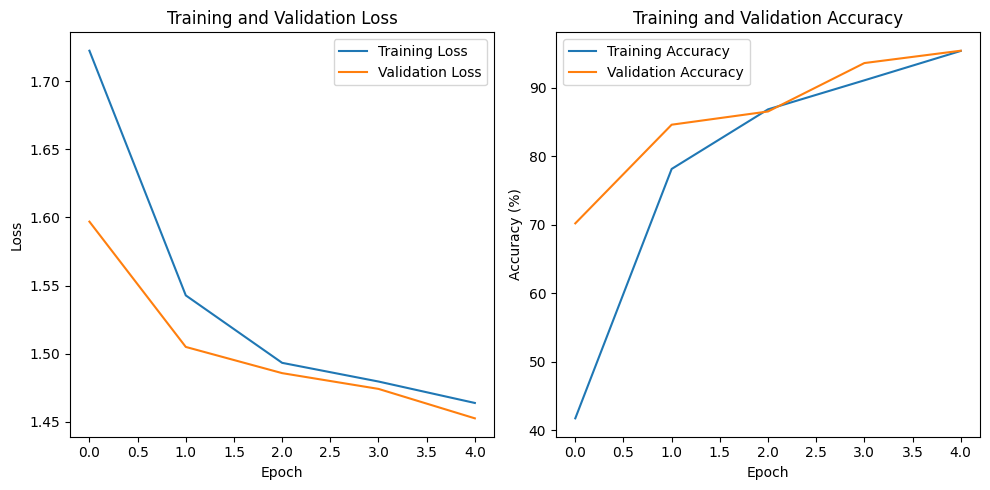

In [12]:
import torch
import matplotlib.pyplot as plt

# Define the device
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(device)
# Move the model to the device
model.to(device)

num_epochs = 5
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    train_correct = 0
    train_total = 0
    
    for images, labels in train_loader:
        optimizer.zero_grad()
        images = images.to(device)  # Move images to device
        labels = labels.to(device)  # Move labels to device
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
        _, predicted = outputs.max(dim=1)  # Get the predicted class indices
        train_total += labels.size(0)
        train_correct += predicted.eq(labels.argmax(dim=1)).sum().item()  # Compare predicted indices with true indices

    train_accuracy = 100 * train_correct / train_total
    train_losses.append(train_loss / len(train_loader))
    train_accuracies.append(train_accuracy)
    
    # Validation loop
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels_onehot in val_loader:  # assuming labels are one-hot encoded
            images = images.to(device)
            labels = torch.argmax(labels_onehot, dim=1).to(device)  # convert one-hot to class indices

            outputs = model(images)
            val_loss += criterion(outputs, labels).item()

            _, predicted = outputs.max(dim=1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(100 * correct / total)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.2f}%, Validation Loss: {val_losses[-1]:.4f}, Validation Accuracy: {val_accuracies[-1]:.2f}%")

# Plotting
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [13]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Test loop
model.eval()
test_loss = 0
correct = 0
total = 0
predicted_list = []
labels_list = []

with torch.no_grad():
    for images, labels_onehot in test_loader:  # assuming labels are one-hot encoded
        images = images.to(device)
        labels = torch.argmax(labels_onehot, dim=1).to(device)  # convert one-hot to class indices

        outputs = model(images)
        test_loss += criterion(outputs, labels).item()

        _, predicted = outputs.max(dim=1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        predicted_list.extend(predicted.cpu().numpy())
        labels_list.extend(labels.cpu().numpy())

test_accuracy = 100 * correct / total
precision = precision_score(labels_list, predicted_list, average='macro')
recall = recall_score(labels_list, predicted_list, average='macro')
f1 = f1_score(labels_list, predicted_list, average='macro')

print(f"Test Loss: {test_loss / len(test_loader):.4f}")
print(f"Test Accuracy: {test_accuracy:.2f}%")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

torch.save(model.state_dict(), 'swin_classification_pytorch_model_weights.pth')


Test Loss: 1.4509
Test Accuracy: 95.45%
Precision: 0.9547
Recall: 0.9561
F1 Score: 0.9544
